## Implementing a Support Vector Machine (SVM) E-Mail Spam Classification Filter

If my middle school english teacher taught me one thing, it was that I should start every essay with a dictionary definition of a word and then struggle to connect it with the topic of the essay. So, in the words of our benevolent overlord, [Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine), 
> Support vector machines (SVMs) are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training examples, each marked for belonging to one of two categories, an SVM training algorithm builds a model that assigns new examples into one category or the other, making it a non-probabilistic binary linear classifier.

In this blog post, I briefly explore how SVMs work, and then show how some out-of-the-box [sklearn](http://scikit-learn.org/stable/) SVM software can be used to build a spam classification filter for your e-mail! This project was inspired heavily by [Andrew Ng's Machine Learning course on Coursera](https://www.coursera.org/learn/machine-learning) which I am [currently completing](https://github.com/kaleko/CourseraML) in python at a reduced pace alongside my Ph.D. thesis work.

### Brief Overview of SVMs

Support Vector Machines (SVMs) are supervised learning models. They are similar to logistic regression (which I show implementations of in this [previous blog post](http://blog.davidkaleko.com/log-regression-particle-physics-event-selection.html)), but with a modified cost function that is computationally advantageous.

To demonstrate, below I show the shape of one term of the cost function for a logistic regression in blue, while I show the shape of the analogous term of the cost function for an SVM in red. I leave the x- and y- axes unlabeled to keep the plot abstract; the functional shapes are sufficient to demonstrate my point!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

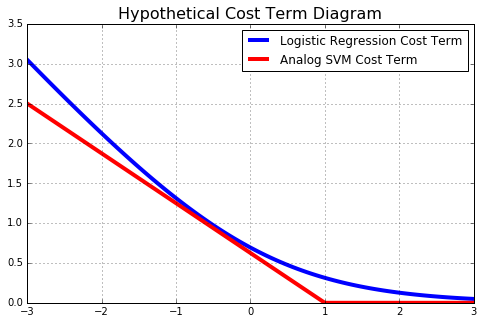

In [2]:
xvals = np.linspace(-3,3,100)
lregtermvals = -np.log(1/(1+np.exp(-xvals)))
svmtermvals  = [0.625 - (2.5/4.0)*x if x < 1. else 0 for x in xvals]
plt.figure(figsize=(8,5))
plot1 = plt.plot(xvals, 
                 lregtermvals,
                 label='Logistic Regression Cost Term',
                 color='blue',linewidth=4)
plot2 = plt.plot(xvals, 
                 svmtermvals,
                 label='Analog SVM Cost Term',
                 color='red',linewidth=4)
plt.grid(True)
plt.title('Hypothetical Cost Term Diagram',fontsize=16)
myleg = plt.legend()

As you can see, logistic regression cost functions are continuous functions involving logs of exponentials while SVMs use simple piecewise linear costs terms. This provides the computational advantage to SVMs that I mentioned earlier.

I'll also note that this piecewise cost structure is what makes an SVM a *large margin classifier*, something which I won't describe in detail but I'll just note that this makes the decision boundary computed by an SVM more robust. I highly suggest checking out the aforementioned Coursera machine learning course in which Andrew Ng steps through the math behind large margin classifiers (though he marks it as "optional" because he uses vector scalar products in his derivation... cakewalk for a physicist!).

Another similarity SVMs have to logistic regressions is that they can be regularized to help find a balance between underfitting (high bias) and overfitting (high variance) the data. While in logistic regressions the regularization parameter is often called lambda, in SVMs the letter *C* is often used... note that *C* is analogous to the *inverse* of lambda. The best way to choose the value of *C* that finds the middleground between underfitting and overfitting the data is to split up your data sample in to three groups: training, cross validation, and test. More on this below when I start actually implementing an SVM!

#### SVMs: Kernels

Lastly, SVMs are so computationally fast that they are able to use *kernels* without running egregiously slowly. In simple terms, a kernel function (as used here) is one that takes as input two data points and returns some measure of similarity between those two data points. Not any function can be considered a kernel though; it has to satisfy [Mercer's Theorem](https://en.wikipedia.org/wiki/Mercer%27s_theorem), but I won't be going into that here. Two common kernels used are *gaussian kernels* and *linear kernels*. 

In the case of the gaussian kernel, the similarity between two points is computed with a gaussian function based on the euclidean distance between those two points (with dimensionality equal to the number of features used to describe those points). One can choose the gaussian width, $\sigma$, to tune how spaced apart points can be to still have them be considered "similar". In the figure below, I draw two sample data sets and have used a gaussian kernel in an SVM to find a decision boundary between the two. The actual code I used to create this plot is shown in [my Coursera class homework solutions](https://github.com/kaleko/CourseraML/blob/master/ex6/ex6.ipynb).

<img src="data/SVM_decisionboundary_fig.png">

In the case of the linear kernel, no kernel is used at all! As readers of this blog post, it's your lucky day; I'm using a linear kernel for this spam classifier!

### SVMs for Spam Classification

Alright enough text already, let's get to the code. In this post I will be using samples of spam and non-spam e-mails supplied by the [SpamAssassin Public Corpus](http://spamassassin.apache.org/publiccorpus/) which I will subdivide into three groups as I mentioned earlier: a training set, a cross validation set, and a test set. An outline of what we're about to do is:
1.  Read in the e-mails.
2.  Preprocess the e-mails to turn their text into a format an SVM can understand.
3.  Subdivide the e-mails into the three sets (training, CV, test).
4.  Initialize an SVM, try different values of the *C* parameter, training the SVM on the training set each time.
5.  Run each trained SVM on the cross validation set and determine which value of $C$ is most appropriate.
6.  Run the best trained SVM on the test set and report how well it worked.


#### What Does the Data Look Like?

In [3]:
import os

data_dir = 'data/svm_spam_data/'

#Let's read in the non-spam e-mails into an array:
nonspam_emails = []
for nonspam_email in os.listdir(data_dir+'easy_ham/'):
    nonspam_emails.append(open( data_dir+'easy_ham/' + nonspam_email, 'r' ).read())

#Let's now read in the spam e-mails into an array:
spam_emails = []
for spam_email in os.listdir(data_dir+'spam/'):
    spam_emails.append(open( data_dir+'spam/' + spam_email, 'r' ).read())

#Let's have a look at the first non-spam e-mail just to see...
print nonspam_emails[1]

From Steve_Burt@cursor-system.com  Thu Aug 22 12:46:39 2002
Return-Path: <Steve_Burt@cursor-system.com>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id BE12E43C34
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:46:38 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:46:38 +0100 (IST)
Received: from n20.grp.scd.yahoo.com (n20.grp.scd.yahoo.com
    [66.218.66.76]) by dogma.slashnull.org (8.11.6/8.11.6) with SMTP id
    g7MBkTZ05087 for <zzzz@example.com>; Thu, 22 Aug 2002 12:46:29 +0100
X-Egroups-Return: sentto-2242572-52726-1030016790-zzzz=example.com@returns.groups.yahoo.com
Received: from [66.218.67.196] by n20.grp.scd.yahoo.com with NNFMP;
    22 Aug 2002 11:46:30 -0000
X-Sender: steve.burt@cursor-system.com
X-Apparently-To: zzzzteana@yahoogroups.com
Received: (EGP: mail-8_1_0_1); 22 Aug 2002 11:46:

#### Processing the E-Mails Into a Format an SVM Can Use

Wow the e-mail above is pretty gross. We're going to have to do some serious work to turn it into some sort of feature vector that an SVM can read in.

To start, let's get rid of all of that header stuff. I'm not sure the best way to do it, but looking at a bunch of these sample e-mails, all the header stuff generally ends in a double new line, '\n\n'. Let's double check that all e-mails (non-spam, and spam) have a double newline in it.

In [4]:
for nonspam_email in nonspam_emails:
    if "\n\n" not in nonspam_email:
        print "This non-spam e-mail didn't have a double newline!"
        print nonspam_email[:500]

for spam_email in spam_emails:
    if "\n\n" not in spam_email:
        print "This spam e-mail didn't have a double newline!"
        print spam_email[:500]

This spam e-mail didn't have a double newline!
mv 1 00001.bfc8d64d12b325ff385cca8d07b84288
mv 10 00010.7f5fb525755c45eb78efc18d7c9ea5aa
mv 100 00100.c60d1c697136b07c947fa180ba3e0441
mv 101 00101.2dfd7ee79ae439b8d9c38e783a137efa
mv 102 00102.2e3969075728dde7a328e05d19b35976
mv 103 00103.8c39bfed2079f865e9dfb75f4416a468
mv 104 00104.886f4a22362f4d3528c3e675878f17f7
mv 105 00105.9790e1c57fcbf7885b7cd1719fb4681b
mv 106 00106.fa6df8609cebb6f0f37aec3f70aa5b9a
mv 107 00107.f1d4194b57840ea6587b9a73ed88e075
mv 108 00108.4506c2ef846b80b9a7beb90315b227


Weirdly the first spam_email seems to be a list of *mv* commands perhaps used when generating this data set... let's just throw that one out, and continue.

In [5]:
spam_emails = spam_emails[1:]

Since all of the e-mails (spam and non-spam) have a double newline, I'm going to be assuming the first occurence of the double newline designates the end of the header garbage. Now I loop through all e-mails and erase the headers.

In [6]:
nonspam_emails = [ email[email.find('\n\n')+4:] for email in nonspam_emails ]
spam_emails    = [ email[email.find('\n\n')+4:] for email in spam_emails    ]

Next I'm going to preprocess each e-mail, meaning I'm going to make everything lowercase, strip out html tags, etc. I'll also change any numbers to the string 'number', this way the SVM can easily treat all numbers the same, since I have no reason to believe '12345' is any more likely to show up in a spam e-mail than '12346'. I also do something similar to any string starting with 'http', strings I think are e-mail addresses, and dollar amounts.

In [7]:
import re #regular expression for e-mail processing

def preProcess( email ):
    """
    Function to do some pre processing (simplification of e-mails).
    Comments throughout implementation describe what it does.
    Input = raw e-mail
    Output = processed (simplified) email
    """
    # Make the entire e-mail lower case
    email = email.lower()
    
    # Strip html tags (strings that look like <blah> where 'blah' does not
    # contain '<' or '>')... replace with a space
    email = re.sub('<[^<>]+>', ' ', email);
    
    #Any numbers get replaced with the string 'number'
    email = re.sub('[0-9]+', 'number', email)
    
    #Anything starting with http or https:// replaced with 'httpaddr'
    email = re.sub('(http|https)://[^\s]*', 'httpaddr', email)
    
    #Strings with "@" in the middle are considered emails --> 'emailaddr'
    email = re.sub('[^\s]+@[^\s]+', 'emailaddr', email);
    
    #The '$' sign gets replaced with 'dollar'
    email = re.sub('[$]+', 'dollar', email);
    
    return email

Next, I take each e-mail and tokenize it (break it up into 'words' which can be defined as strings separated by a space, or separated by some other delimiters that I use). Each token (or word) is then [stemmed](https://en.wikipedia.org/wiki/Stemming), which means I attempt to shorten each word to its root. That way, words like *mortgage* and *mortgaging* are both stemmed to *mortgag* and will therefore be treated the same way by the SVM. To do the actual stemming, I use a stemmer module from the [Natural Language Toolkit](http://www.nltk.org/) package in python.

In [8]:
import nltk, nltk.stem.porter

def email2TokenList( raw_email ):
    """
    Function that takes in preprocessed (simplified) email, tokenizes it,
    stems each word, and returns an (ordered) list of tokens in the e-mail
    """
    stemmer = nltk.stem.porter.PorterStemmer()
    
    email = preProcess( raw_email )

    #Split the e-mail into individual words (tokens) (split by the delimiter ' ')
    #but also split by delimiters '@', '$', '/', etc etc
    #Splitting by many delimiters is easiest with re.split()
    tokens = re.split('[ \@\$\/\#\.\-\:\&\*\+\=\[\]\?\!\(\)\{\}\,\'\"\>\_\<\;\%]', email)
    
    #Loop over each word (token) and use a stemmer to shorten it,
    tokenlist = []
    for token in tokens:
        
        #Remove any non alphanumeric characters
        token = re.sub('[^a-zA-Z0-9]', '', token);

        #Use the Porter stemmer to stem the word
        stemmed = stemmer.stem( token )
        
        #Throw out empty tokens
        if not len(token): continue
            
        #Store a list of all stemmed words
        tokenlist.append(stemmed)
            
    return tokenlist

After an e-mail is handed to this function, *email2TokenList*, what comes out is a list of stemmed words. However, the number of unique stemmed words throughout all of the e-mails is very large... perhaps too large for each unique stemmed word to be used as a feature for the SVM to consider when it attempts to classify an e-mail as spam or non-spam. Also, words that occur very rarely in the training set might only occur in a few e-mails, which could lead to overfitting the data set. To handle these two problems, I'll do the following: loop over all the e-mails (spam, and non-spam) and take the 500 most common words overall as my vocabulary list.

I accomplish this in a somewhat hacky way. I concatenate all emails to form one giant e-mail, tokenize and stem it, and use function from within the [collections module](https://docs.python.org/2/library/collections.html) to count the number of occurrences of each word. I'll make a collections.Counter object, which is a high performance python container with super useful functionality like the *most_common(N)* function, which returns the *N* most common tokens in the collection. I.E. exactly what I want!

In [9]:
giant_nonspam_email = [ ' '.join(nonspam_emails[:]) ]
giant_spam_email    = [ ' '.join(spam_emails[:])    ]
giant_total_email   = giant_nonspam_email[0]+giant_spam_email[0]

In [10]:
from collections import Counter
word_counts = Counter(email2TokenList(giant_total_email))

In [11]:
print 'The total number of unique stemmed tokens is: '
print len(word_counts)
print 'The ten most common stemmed tokens are:'
print [ str(x[0]) for x in word_counts.most_common(10) ]

The total number of unique stemmed tokens is: 
45374
The ten most common stemmed tokens are:
['number', 'the', 'to', 'and', 'of', 'a', 'in', 'i', 'is', 'it']


What I do here is get the 1000 most common tokens and assign them each a unique number, 1 through 1000. I store this information in a dictionary, where the key is the stemmed token and the value is the unique number.

In [12]:
common_words = [ str(x[0]) for x in word_counts.most_common(1000) ]
vocab_dict = dict((item, i) for i, item in enumerate(common_words))

Up next is converting each e-mail into a list of these indices, then further converting that into a feature vector of shape (1000, 1). This vector will contain only 1's and 0's... for example, if the e-mail has only three words whose indices in the vocab_dict are 3, 9, 14, then the 3rd, 9th, and 14th element of the vector will be 1's while the other 4997 elements in the vector will be 0's.

In [13]:
def email2VocabIndices( raw_email, vocab_dict ):
    """
    Function that takes in a raw email and returns a list of indices corresponding
    to the location in vocab_dict for each stemmed word in the email.
    """
    tokenlist = email2TokenList( raw_email )
    index_list = [ vocab_dict[token] for token in tokenlist if token in vocab_dict ]
    return index_list

def email2FeatureVector( raw_email, vocab_dict ):
    """
    Function that takes as input a raw email, and returns a vector of shape
    (n,1) where n is the size of the vocab_dict.
    The first element in this vector is 1 if the vocab word with index == 1
    is in the raw_email, 0 otherwise.
    """
    n = len(vocab_dict)
    result = np.zeros((n,1))
    vocab_indices = email2VocabIndices( raw_email, vocab_dict )
    for idx in vocab_indices:
        result[idx] = 1
    return result

Woohoo! Now we can turn each e-mail into a feature vector and we can hand it to an SVM. Let's *finally* get into the actual SVM portion of this blog post!

#### Training the SVM for Spam Classification

What I want to end up handing an SVM is a training set with, say, *n* samples in it. I need to create two things:
1.  A feature matrix, *Xtrain* with shape ( *n*, 1000 ) [because my vocab dictionary is 1000 words long], which is formed by stacking together a feature vector for each e-mail. This matrix will contain both spam and nonspam e-mails.
2.  A classification vector, *ytrain* with shape ( *n*, 1 ) which contains the labels of each corresponding e-mail in the *Xtrain* matrix (1 for spam, 0 for nonspam).

I've chosen the ratio of training set size to cross validation set size to test set size to be roughly 60/20/20. Let's build my *Xtrain* matrix and *ytrain* vector from the first 60% of the nonspam e-mails and the first 60% of the spam e-mails, then build the *Xcv* and *ycv* objects from the next 20%, and lastly the *Xtest* and *ytest* objects from the remaining 20%.

In [15]:
#Build the training X matrix and y vector
n_nonspam_train = int(len(nonspam_emails)*0.6)
n_spam_train    = int(len(spam_emails)   *0.6)

nonspam_train = [email2FeatureVector( x, vocab_dict ) 
                 for x in nonspam_emails[:n_nonspam_train]]
spam_train    = [email2FeatureVector( x, vocab_dict ) 
                 for x in spam_emails   [:n_spam_train   ]]

Xtrain = np.concatenate(nonspam_train+spam_train,axis=1).T
ytrain = np.concatenate(
    (np.zeros((n_nonspam_train,1)),
     np.ones((n_spam_train,1))
    ), axis=0)


#Build the CV X matrix and y vector
n_nonspam_cv = int(len(nonspam_emails)*0.2)
n_spam_cv    = int(len(spam_emails)   *0.2)

nonspam_cv = [email2FeatureVector( x, vocab_dict ) 
                 for x in nonspam_emails[n_nonspam_train:n_nonspam_train+n_nonspam_cv]]
spam_cv    = [email2FeatureVector( x, vocab_dict ) 
                 for x in spam_emails   [n_spam_train:n_spam_train+n_spam_cv         ]]

Xcv = np.concatenate(nonspam_cv+spam_cv,axis=1).T
ycv = np.concatenate(
    (np.zeros((n_nonspam_cv,1)),
     np.ones((n_spam_cv,1))
    ), axis=0)

#Build the test X matrix and y vector
n_nonspam_test = len(nonspam_emails) - n_nonspam_train - n_nonspam_cv
n_spam_test    = len(spam_emails)    - n_spam_train - n_spam_cv

nonspam_test = [email2FeatureVector( x, vocab_dict ) 
                 for x in nonspam_emails[-n_nonspam_test:]]
spam_test    = [email2FeatureVector( x, vocab_dict ) 
                 for x in spam_emails   [-n_spam_test:   ]]

Xtest = np.concatenate(nonspam_test+spam_test,axis=1).T
ytest = np.concatenate(
    (np.zeros((n_nonspam_test,1)),
     np.ones((n_spam_test,1))
    ), axis=0)

Now we have our training set, our cross-validation set, and our test set finally in the format we want. 

As a reminder, the purpose of the cross-validation set was to use it to choose our parameter, *C* without baising ourselves when we report our final performance on the test set.

Let's create several instances of sklearn linear kernel SVM's, each with a different *C* parameter. We'll train each on the training set and evaluate the performance of each on the cross-validation set. Finally, we'll choose the instance with the best performance and run it on the test set to see how well our model works!

In [16]:
from sklearn import svm #SVM software
# Run the SVM training (with C = 0.1) using SVM software. 

myCs = [ 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0 ]
myErrors = []
myErrors_train = []

for myC in myCs:
    
    # Make an instance of an SVM with C=myC and 'linear' kernel
    linear_svm = svm.SVC(C=myC, kernel='linear')

    # Now we fit the SVM to our Xtrain matrix, given the labels ytrain
    linear_svm.fit( Xtrain, ytrain.flatten() )
    
    # Determine how well this SVM works by computing the
    # classification error on the cross-validation set
    cv_predictions = linear_svm.predict(Xcv).reshape((ycv.shape[0],1))
    cv_error = 100. * float(sum(cv_predictions != ycv))/ycv.shape[0]
    myErrors.append( cv_error )

    # While we're at it, do the same for the training set error
    train_predictions = linear_svm.predict(Xtrain).reshape((ytrain.shape[0],1))
    train_error = 100. * float(sum(train_predictions != ytrain))/ytrain.shape[0]
    myErrors_train.append( train_error )

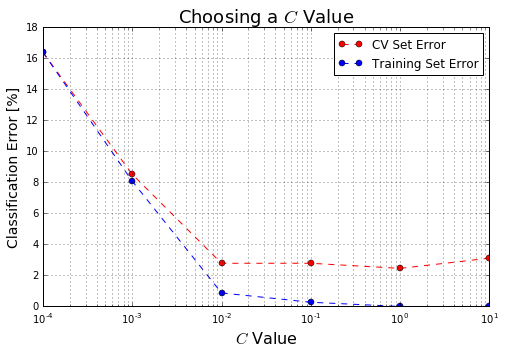

In [17]:
plt.figure(figsize=(8,5))
plt.plot(myCs,myErrors,'ro--',label='CV Set Error')
plt.plot(myCs,myErrors_train,'bo--',label='Training Set Error')
plt.grid(True,'both')
plt.xlabel('$C$ Value',fontsize=16)
plt.ylabel('Classification Error [%]',fontsize=14)
plt.title('Choosing a $C$ Value',fontsize=18)
plt.xscale('log')
myleg = plt.legend()

Here we can see that the performance on the training set improves as *C* increases. With a small *C* value, we are underfitting the training set and therefore the performance on the CV set is bad. With a large *C* value, we are likely overfitting the training set as seen by the above blue curve. A good intermediate *C* value can be extracted from the red curve on the above plot. Any value between 0.001 and 1 are acceptable, but above that point the CV set error begins increasing again due to overfitting. **Let's go with a *C* value of 0.1.**

Huzzah! Let's see how well we perform on the test set!

In [18]:
best_svm = svm.SVC(C=0.1, kernel='linear')
best_svm.fit( Xtrain, ytrain.flatten() )

test_predictions = best_svm.predict(Xtest).reshape((ytest.shape[0],1))
test_acc = 100. * float(sum(test_predictions == ytest))/ytest.shape[0]
print 'Test set accuracy = %0.2f%%' % test_acc

Test set accuracy = 98.69%


### Awesome

We've successfully accomplished our goal of training a support vector machine to classify e-mails as spam, or not. Let's recap what we accomplished:
1.  We found a source of labeled spam, and non-spam e-mails online.
2.  We processed each e-mail by stripping miscellaneous headers, tokenizing, and stemming the resulting tokens.
3.  We sifted through all of the e-mails to get a "vocabulary list" of the most common tokens.
4.  We divided the e-mails into three sets: train, cross-validation, and test.
5.  We converted the e-mails into feature vectors, and built feature matrices and label vectors in the form that an SVM can understand.
6.  We constructed SVMs with various parameters and chose the model that worked best on the cross-validation set.

### **Finally, we tested our best model on the test set and found it has 98.69% accuracy to identify spam e-mails!**

Thanks for coming along for the ride. I hope you enjoyed this blog post!